Libraries

In [1]:
# External Libraries
import numpy as np
import pandas as pd
from itertools import combinations
import warnings
warnings.filterwarnings("ignore")
import os
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed
import joblib
import json
from pathlib import Path
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp, Pauli, Statevector
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import EstimatorV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import NoiseModel

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score, precision_score, recall_score

Load backend for fake noise

In [24]:
runtime_service = QiskitRuntimeService(
    token = 'RyY3IAqFaCATY4Ipapkww91nwsWmW1AJgjJpXY3aNWlD',
    channel= 'ibm_cloud',
    instance= 'crn:v1:bluemix:public:quantum-computing:eu-de:a/2c7afd2718fe41cf912e8ad6e77f57c7:8c3584e4-f5c6-4940-be8b-82166457b586::',
)

backend_name = "ibm_aachen"
ibm_backend = runtime_service.backend(backend_name)

qiskit_runtime_service._discover_account:WARNING:2025-10-15 23:49:38,125: Loading account with the given token. A saved account will not be used.


Dataset
 - load dataset
 - keep only most important features, based on the calculations in file Feature_selection.ipynb

In [9]:
dataset_save = "Dataset/Toxicity-13F.csv"
dataset_5F = "Dataset/Toxicity-5F.csv"
dataset_8F = "Dataset/Toxicity-8F.csv"
    
df = pd.read_csv(dataset_save)
#print(df['Class'].value_counts())
df['Class'] = df['Class'].apply(lambda v: 1 if str(v).strip().lower().startswith('non') else 0)
#print(df['Class'].value_counts())
#df.head()

df5 = pd.read_csv(dataset_5F)
#print(df5['Class'].value_counts())
#df5.head()

df8 = pd.read_csv(dataset_8F)
#print(df5['Class'].value_counts())
#df5.head()



Global parameters

In [3]:
N_QUBITS = df5.shape[1] - 1  # N_QUBITS = number of features
TAU = 20e-9              # 30 ns (seconds)
A0 = 2 * np.pi * 15e9       # rad/s
B0 = 2 * np.pi * 11e9       # rad/s
REPS = 50
M = 40
#REPS = 64
#M = int(np.ceil(2000 / REPS))    # -> 32 slices when REPS=64
DELTA_T = TAU / M
ORDER = 2                # Suzuki-Trotter order
RANDOM_STATE = 42
N_SPLITS = 5

# added by Jiri
OPTIMIZATION_LEVEL = 0
SHOTS = 1024
NOISE_MODEL = None

Metrics directly (classically)

In [4]:
def run_experiment_classical(X, y):
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

    metrics = { 
        'auc': [], 
        'f1': [], 
        'bal_acc': [], 
        'prec_0': [], 
        'rec_0': [], 
        'prec_1': [], 
        'rec_1': [] 
    }

    fold_idx = 0
    for train_idx, test_idx in skf.split(X, y):
        fold_idx += 1
        Xtrain, Xtest = X[train_idx], X[test_idx]
        ytrain, ytest = y[train_idx], y[test_idx]

        # Preprocessing
        imputer = SimpleImputer(strategy='median')
        imputer.fit(Xtrain)
        Xtrain_im = imputer.transform(Xtrain)
        Xtest_im = imputer.transform(Xtest)

        scaler = StandardScaler()
        scaler.fit(Xtrain_im)
        Xtrain_std = scaler.transform(Xtrain_im)
        Xtest_std = scaler.transform(Xtest_im)

        # Classifier
        clf = GradientBoostingClassifier(random_state=RANDOM_STATE)
        clf.fit(Xtrain_std, ytrain)
        ypred = clf.predict(Xtest_std)
        yproba = clf.predict_proba(Xtest_std)[:, 1]

        # Metrics
        metrics['auc'].append(roc_auc_score(ytest, yproba))
        metrics['f1'].append(f1_score(ytest, ypred, zero_division=0))
        metrics['bal_acc'].append(balanced_accuracy_score(ytest, ypred))
        metrics['prec_0'].append(precision_score(ytest, ypred, pos_label=0, zero_division=0))
        metrics['rec_0'].append(recall_score(ytest, ypred, pos_label=0, zero_division=0))
        metrics['prec_1'].append(precision_score(ytest, ypred, pos_label=1, zero_division=0))
        metrics['rec_1'].append(recall_score(ytest, ypred, pos_label=1, zero_division=0))

    # Print median metrics
    print("\n=== Median metrics over 5 folds (classical only) ===")
    for k, v in metrics.items():
        print(f"{k:8s}: {np.median(v):.4f}")

    return metrics

In [11]:
if __name__ == "__main__":
    print("Whole dataset:")
    X = df.drop(columns=['Class']).values
    y = df['Class'].values

    metrics_classical = run_experiment_classical(X, y)

    print("\n")
    print("Top 5 relevant features:")
    X5 = df5.drop(columns=['Class']).values
    y5 = df5['Class'].values
    metrics_classical_top5 = run_experiment_classical(X5, y5)

    print("\n")
    print("Top 8 relevant features:")
    X8 = df8.drop(columns=['Class']).values
    y8 = df8['Class'].values
    metrics_classical_top8 = run_experiment_classical(X8, y8)

Whole dataset:

=== Median metrics over 5 folds (classical only) ===
auc     : 0.7075
f1      : 0.8085
bal_acc : 0.6601
prec_0  : 0.6000
rec_0   : 0.4167
prec_1  : 0.7586
rec_1   : 0.8261


Top 5 relevant features:

=== Median metrics over 5 folds (classical only) ===
auc     : 0.6341
f1      : 0.7083
bal_acc : 0.5059
prec_0  : 0.3333
rec_0   : 0.2727
prec_1  : 0.6667
rec_1   : 0.7391


Top 8 relevant features:

=== Median metrics over 5 folds (classical only) ===
auc     : 0.6087
f1      : 0.7600
bal_acc : 0.5494
prec_0  : 0.4000
rec_0   : 0.2727
prec_1  : 0.7037
rec_1   : 0.8261


QFMs

- Helper functions

In [13]:
# -------------------------
# Helper building functions for Hamiltonians
# -------------------------

def print_circuit_specs(circuit):
    print(
        f"""
    Quantum circuit {circuit.name} specifications
    -----------------------------

                    Depth: {circuit.depth()}
                Gate count: {len(circuit)}
        Nonlocal gate count: {circuit.num_nonlocal_gates()}
            Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}
    """
    )

def plot_metrics_bar(metrics_1, metrics_2):
    # Compute median of each metric
    metric_names = list(metrics_1.keys())

    metric_values_1 = [np.median(metrics_1[m]) for m in metric_names]
    metric_values_2 = [np.median(metrics_2[m]) for m in metric_names]

    # plot
    x = np.arange(len(metric_names))
    width = 0.35
    fig, ax = plt.subplots(figsize=(6, 3))
    bars1 = ax.bar(x - width/2, metric_values_1, width, label='Classical only', color='blue')
    bars2 = ax.bar(x + width/2, metric_values_2, width, label='Quantum_only', color='orange')
    ax.set_ylabel('Mean Value')
    ax.set_title('Comparison of Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(metric_names)
    ax.legend()
    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def s_of_t(t, tau=TAU):
    # s(t) = sin^2( (pi/2) * sin^2(pi t / (2 tau)) )
    inner = np.sin(np.pi * t / (2 * tau)) ** 2
    return np.sin((np.pi / 2) * inner) ** 2

def A_of_t(t): 
    return A0 * (1.0 - s_of_t(t))

def B_of_t(t): 
    return B0 * s_of_t(t)

def build_HD(n):
    #H_D = - sum_i X_i represented as a SparsePauliOp
    labels = []
    coeffs = []
    for i in range(n):
        s = ['I'] * n
        s[i] = 'X'
        labels.append(''.join(s))
        coeffs.append(-1.0)
    pauli_list = [Pauli(label) for label in labels]
    return SparsePauliOp(pauli_list, coeffs)

def build_HP_from_sample(x_std, Jij):
    # Problem Hamiltonian HP(x) = sum_i hi Z_i + sum_{i<j} Jij Z_i Z_j
    # where hi = x_i and Jij is correlation matrix entries.
    n = len(x_std)
    labels = []
    coeffs = []
    # local fields
    for i in range(n):
        s = ['I'] * n
        s[i] = 'Z'
        labels.append(''.join(s))
        coeffs.append(float(x_std[i]))
    # pairwise ZZ
    for i, j in combinations(range(n), 2):
        s = ['I'] * n
        s[i] = 'Z'
        s[j] = 'Z'
        labels.append(''.join(s))
        coeffs.append(float(Jij[i, j]))
    pauli_list = [Pauli(label) for label in labels]
    return SparsePauliOp(pauli_list, coeffs)

def make_evolution_circuit(n_qubits, HP_op_time_dep_fn):
    qc = QuantumCircuit(n_qubits)
    # initial |+>^{n}
    for q in range(n_qubits):
        qc.h(q)

    # Prebuild H_D (Pauli sum op)
    HD_op = build_HD(n_qubits)

    # Append m slices. For slice k (0..m-1) freeze at midpoint t_{k+1/2} = (k+0.5)*dt
    for k in range(M):
        t_mid = (k + 0.5) * DELTA_T
        A = A_of_t(t_mid)
        B = B_of_t(t_mid)
        HP_mid = HP_op_time_dep_fn(k)

        # H_slice = A * HD + B * HP_mid
        H_slice = (A * HD_op) + (B * HP_mid)

        evo_gate = PauliEvolutionGate(H_slice, time=DELTA_T, synthesis=SuzukiTrotter(order=ORDER, reps=REPS))
        qc.append(evo_gate, qc.qubits)

    return qc

def build_circuit_for_sample(x_std, Jij):
    n = len(x_std)
    HP_op = build_HP_from_sample(x_std, Jij)
    qc = make_evolution_circuit(n, lambda k: HP_op)
    return qc

def combine_features(X_classical, X_quantum, gamma_q=1.0, apply_scaling=True):
    if apply_scaling:
        qs = StandardScaler()
        Xq_scaled = qs.fit_transform(X_quantum)
    else:
        Xq_scaled = X_quantum.copy()

    Xq_scaled *= float(gamma_q)
    X_combined = np.hstack([X_classical, Xq_scaled])
    return X_combined, qs

- Feature extraction

In [39]:
"""
def run_quantum_feature_extraction(X_std, Jij, n_qubits=N_QUBITS, shots=SHOTS, optimization_level=OPTIMIZATION_LEVEL, noise_model=NOISE_MODEL):
    n_samples = X_std.shape[0]
    features = np.zeros((n_samples, n_qubits), dtype=float)

    if noise_model is None:
        simulator = AerSimulator(method="statevector", shots=shots)
        np.random.seed(RANDOM_STATE)

        simulator.options.seed_simulator = RANDOM_STATE
        simulator.options.seed_transpiler = RANDOM_STATE

        simulator.set_options(seed_simulator=RANDOM_STATE)
    else:
        simulator = AerSimulator(method="statevector", shots=shots, noise_model=noise_model)
    estimator = EstimatorV2(mode=simulator)
    pass_manager = generate_preset_pass_manager(backend=simulator, optimization_level=optimization_level)

    # Prebuild single-qubit Z observables (SparsePauliOp) for expectation readout
    z_observables = []
    for i in range(n_qubits): 
        s = ['I'] * n_qubits 
        s[i] = 'Z' 
        z_observables.append(SparsePauliOp([Pauli(''.join(s))], [1.0]))

    with tqdm(total=n_samples, desc="Aer features", unit="sample", dynamic_ncols=True) as pbar:
        for idx in range(n_samples):
            qc = build_circuit_for_sample(X_std[idx], Jij)
            qc_transpiled = pass_manager.run(qc)

            # Estimate <Z_i> for each qubit i
            job = estimator.run([(qc_transpiled, pauli_observables)])
            pub_result = job.result()[0]
            #features[idx, :] = pub_result.data.evs
            pbar.update(1)

    return features
"""

def run_quantum_feature_extraction(X_std, Jij,
                                   n_qubits=N_QUBITS,
                                   shots=SHOTS,
                                   optimization_level=OPTIMIZATION_LEVEL,
                                   noise_model=NOISE_MODEL):
    n_samples = X_std.shape[0]
    n_features = 3 * n_qubits
    features = np.zeros((n_samples, n_features), dtype=float)

    # Prepare simulator / estimator and pass manager (keeps your original seeding behavior)
    if noise_model is None:
        simulator = AerSimulator(method="statevector", shots=shots)
        np.random.seed(RANDOM_STATE)
        simulator.options.seed_simulator = RANDOM_STATE
        simulator.options.seed_transpiler = RANDOM_STATE
        simulator.set_options(seed_simulator=RANDOM_STATE)
    else:
        simulator = AerSimulator(method="statevector", shots=shots, noise_model=noise_model)

    estimator = EstimatorV2(mode=simulator)
    pass_manager = generate_preset_pass_manager(backend=simulator, optimization_level=optimization_level)

    # Pre-build observables per basis (lists of length n_qubits)
    pauli_obs_by_basis = {}
    for basis_char in ("X", "Y", "Z"):
        obs_list = []
        for i in range(n_qubits):
            s = ["I"] * n_qubits
            s[i] = basis_char
            obs_list.append(SparsePauliOp([Pauli("".join(s))], [1.0]))
        pauli_obs_by_basis[basis_char] = obs_list

    # Map basis -> column offset within the 3-per-qubit block
    basis_to_col_offset = {"X": 0, "Y": 1, "Z": 2}

    with tqdm(total=n_samples, desc="Aer features (sep bases)", unit="sample", dynamic_ncols=True) as pbar:
        for idx in range(n_samples):
            qc = build_circuit_for_sample(X_std[idx], Jij)
            qc_transpiled = pass_manager.run(qc)

            # For each basis run the estimator once (so 3 estimator.run calls per sample)
            for basis_char in ("X", "Y", "Z"):
                obs_list = pauli_obs_by_basis[basis_char]
                job = estimator.run([(qc_transpiled, obs_list)])
                pub_result = job.result()[0]
                evs = np.asarray(pub_result.data.evs, dtype=float)  # length == n_qubits

                # place evs into the feature vector:
                # feature columns for qubit q are at positions 3*q + offset
                offset = basis_to_col_offset[basis_char]
                features[idx, offset::3] = evs  # fill every 3rd column starting at offset

            pbar.update(1)

    return features


- Run experiment

In [12]:
def _make_meta():
    return {
    "REPS": REPS,
    "M": M,
    "ORDER": ORDER,
    "DELTA_T": DELTA_T,
    "A0": A0,
    "B0": B0,
    "TAU": TAU,
    "RANDOM_STATE": RANDOM_STATE
    }

def run_experiment(X, y, outdir):
    outdir = Path(f"saved_models/{outdir}")
    outdir.mkdir(parents=True, exist_ok=True)

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

    metrics = { 'auc': [], 'f1': [], 'bal_acc': [], 'prec_0': [], 'rec_0': [], 'prec_1': [], 'rec_1': [] }

    fold_idx = 0 
    for train_idx, test_idx in skf.split(X, y): 
        fold_idx += 1 
        Xtrain, Xtest = X[train_idx], X[test_idx] 
        ytrain, ytest = y[train_idx], y[test_idx]
     
        # preprocessing 
        imputer = SimpleImputer(strategy='median') 
        imputer.fit(Xtrain) 
        Xtrain_im = imputer.transform(Xtrain) 
        Xtest_im = imputer.transform(Xtest) 

        scaler = StandardScaler() 
        scaler.fit(Xtrain_im) 
        Xtrain_std = scaler.transform(Xtrain_im) 
        Xtest_std = scaler.transform(Xtest_im) 

        # Jij computed from training set Pearson correlations, diag set to 0 
        rho = np.corrcoef(Xtrain_std, rowvar=False) 
        np.fill_diagonal(rho, 0.0) 
        Jij = rho.copy() 

        # Quantum features for all training and test samples 
        print(f"Fold {fold_idx}: computing quantum features for {len(Xtrain_std)} train + {len(Xtest_std)} test samples...") 
        Xtilde_train = run_quantum_feature_extraction(Xtrain_std, Jij, n_qubits=N_QUBITS,shots=SHOTS, optimization_level=OPTIMIZATION_LEVEL, noise_model=NOISE_MODEL)
        Xtilde_test = run_quantum_feature_extraction(Xtest_std, Jij, n_qubits=N_QUBITS,shots=SHOTS, optimization_level=OPTIMIZATION_LEVEL, noise_model=NOISE_MODEL)
        
        # Augment classical features with quantum features
        gamma_q = 1.0
        Xaug_train = np.hstack([Xtrain_std, gamma_q * Xtilde_train]).astype(np.float32) 
        Xaug_test = np.hstack([Xtest_std, gamma_q * Xtilde_test]).astype(np.float32) 
        
        # classifier 
        clf = GradientBoostingClassifier(random_state=RANDOM_STATE) 
        clf.fit(Xaug_train, ytrain) 
        ypred = clf.predict(Xaug_test) 
        yproba = clf.predict_proba(Xaug_test)[:, 1] 
        
        # metrics 
        metrics['auc'].append(roc_auc_score(ytest, yproba)) 
        metrics['f1'].append(f1_score(ytest, ypred, zero_division=0)) 
        metrics['bal_acc'].append(balanced_accuracy_score(ytest, ypred)) 
        metrics['prec_0'].append(precision_score(ytest, ypred, pos_label=0, zero_division=0)) 
        metrics['rec_0'].append(recall_score(ytest, ypred, pos_label=0, zero_division=0)) 
        metrics['prec_1'].append(precision_score(ytest, ypred, pos_label=1, zero_division=0)) 
        metrics['rec_1'].append(recall_score(ytest, ypred, pos_label=1, zero_division=0)) 

    metrics_median = { k: np.median(v) for k, v in metrics.items() }

    # Save artifacts
    model_path = outdir / "model.joblib"
    imputer_path = outdir / "imputer.joblib"
    scaler_path = outdir / "scaler.joblib"
    Jij_path = outdir / "Jij.npy"
    meta_path = outdir / "meta.json"
    metrics_path = outdir / "metrics.json"

    joblib.dump(clf, model_path)
    joblib.dump(imputer, imputer_path)
    joblib.dump(scaler, scaler_path)
    np.save(Jij_path, Jij)
    with open(meta_path, "w") as fh:
        json.dump(_make_meta(), fh, indent=2)
    with open(metrics_path, "w") as fh:
        json.dump(metrics_median, fh, indent=2)

    return metrics_median



Train model and get metrics

In [67]:
if __name__ == "__main__":
    X = df5.drop(columns=['Class']).values
    y = df5['Class'].values
    NOISE_MODEL = None
    metrics_quantum_top5 = run_experiment(X,y, outdir="quantum_top5_50r_40m")

    #NOISE_MODEL = NoiseModel.from_backend(ibm_backend)
    #metrics_quantum_top5_noise = run_experiment(X,y, outdir="quantum_top5_noise")

Fold 1: computing quantum features for 136 train + 35 test samples...


Aer features (sep bases): 100%|██████████| 35/35 [02:41<00:00,  4.60s/sample]


Fold 2: computing quantum features for 137 train + 34 test samples...


Aer features (sep bases): 100%|██████████| 34/34 [02:41<00:00,  4.74s/sample]


Fold 3: computing quantum features for 137 train + 34 test samples...


Aer features (sep bases): 100%|██████████| 34/34 [02:32<00:00,  4.47s/sample]


Fold 4: computing quantum features for 137 train + 34 test samples...


Aer features (sep bases): 100%|██████████| 34/34 [02:42<00:00,  4.79s/sample]


Fold 5: computing quantum features for 137 train + 34 test samples...


Aer features (sep bases): 100%|██████████| 34/34 [02:37<00:00,  4.63s/sample]


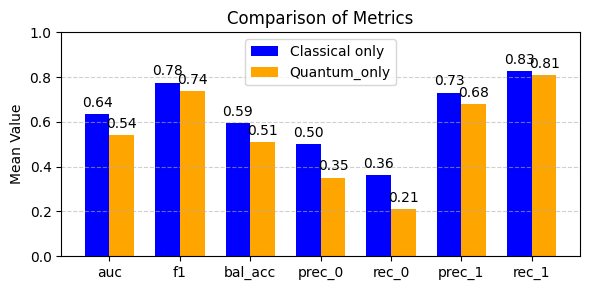

In [68]:
metrics_quantum_top5 = json.load(open("saved_models/quantum_top5_50R_40m/metrics.json"))
plot_metrics_bar(metrics_classical_top5, metrics_quantum_top5)

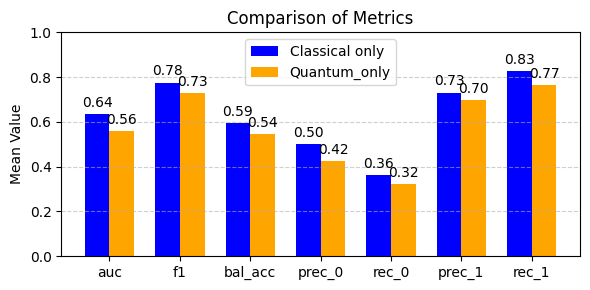

In [64]:
metrics_quantum_top5 = json.load(open("saved_models/quantum_top5_1rep/metrics.json"))
plot_metrics_bar(metrics_classical_top5, metrics_quantum_top5)

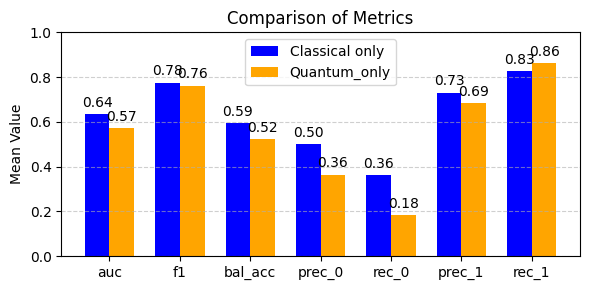

In [ ]:
metrics_quantum_top5 = json.load(open("saved_models/quantum_top5_50R_40m/metrics.json"))
plot_metrics_bar(metrics_classical_top5, metrics_quantum_top5)

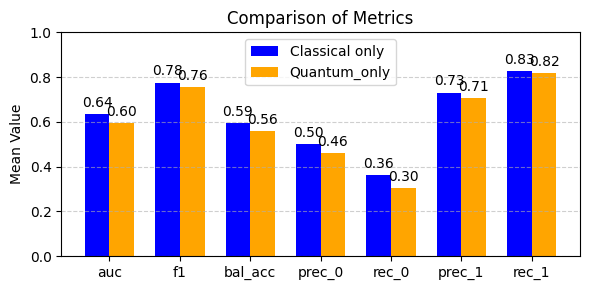

In [54]:
metrics_quantum_top5 = json.load(open("saved_models/quantum_top5_1rep/metrics.json"))
plot_metrics_bar(metrics_classical_top5, metrics_quantum_top5)

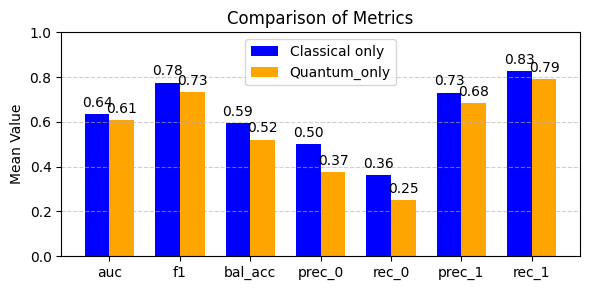

In [52]:
metrics_quantum_top5 = json.load(open("saved_models/quantum_top5_1rep/metrics.json"))
plot_metrics_bar(metrics_classical_top5, metrics_quantum_top5)

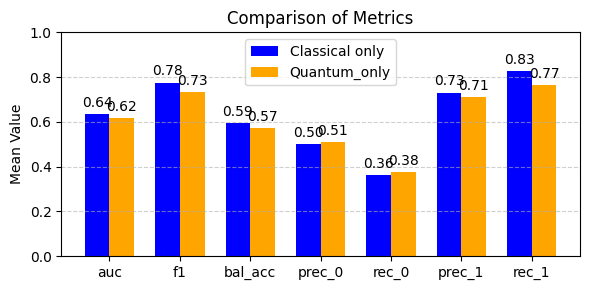

In [47]:
metrics_quantum_top5 = json.load(open("saved_models/quantum_top5_tryout/metrics.json"))
plot_metrics_bar(metrics_classical_top5, metrics_quantum_top5)

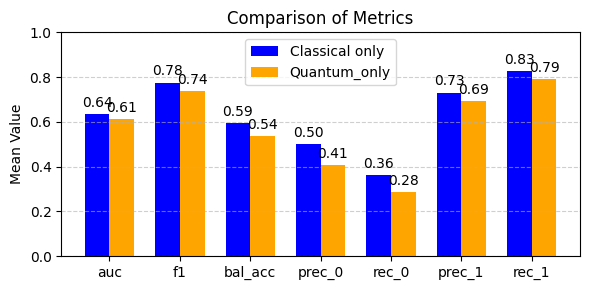

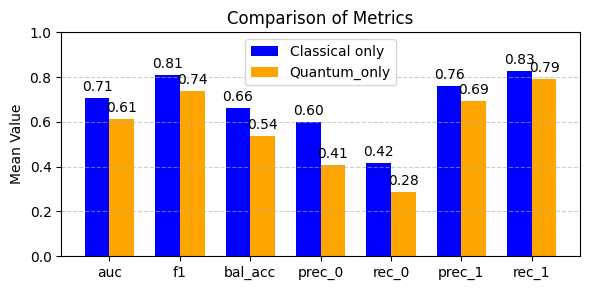

In [44]:
metrics_quantum_top5 = json.load(open("saved_models/quantum_top5_tryout/metrics.json"))
plot_metrics_bar(metrics_classical_top5, metrics_quantum_top5)
plot_metrics_bar(metrics_classical, metrics_quantum_top5)

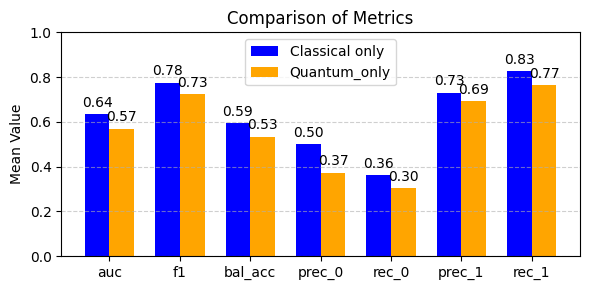

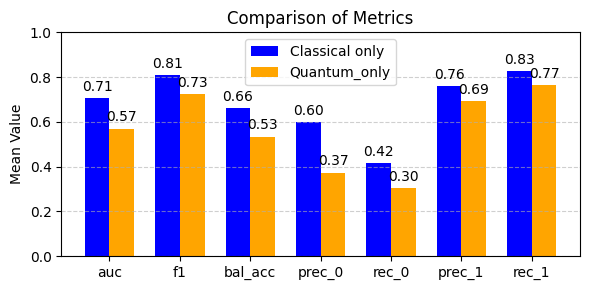

In [41]:
metrics_quantum_top5 = json.load(open("saved_models/quantum_top5_tryout/metrics.json"))
plot_metrics_bar(metrics_classical_top5, metrics_quantum_top5)
plot_metrics_bar(metrics_classical, metrics_quantum_top5)

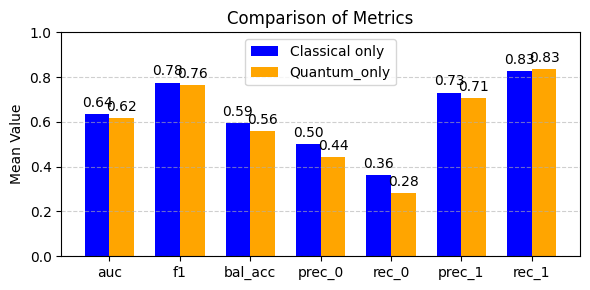

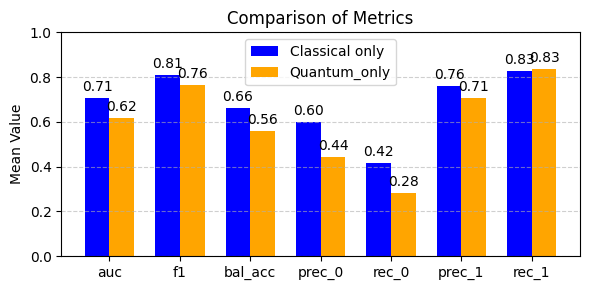

In [33]:
metrics_quantum_top5 = json.load(open("saved_models/quantum_top5_noiseless/metrics.json"))
plot_metrics_bar(metrics_classical_top5, metrics_quantum_top5)
plot_metrics_bar(metrics_classical, metrics_quantum_top5)